# Initialization (FastKAN)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import *

class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve 
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim, out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class AttentionWithFastKANTransform(nn.Module):
    
    def __init__(
        self,
        q_dim: int,
        k_dim: int,
        v_dim: int,
        head_dim: int,
        num_heads: int,
        gating: bool = True,
    ):
        super(AttentionWithFastKANTransform, self).__init__()

        self.num_heads = num_heads
        total_dim = head_dim * self.num_heads
        self.gating = gating
        self.linear_q = FastKANLayer(q_dim, total_dim)
        self.linear_k = FastKANLayer(k_dim, total_dim)
        self.linear_v = FastKANLayer(v_dim, total_dim)
        self.linear_o = FastKANLayer(total_dim, q_dim)
        self.linear_g = None
        if self.gating:
            self.linear_g = FastKANLayer(q_dim, total_dim)
        # precompute the 1/sqrt(head_dim)
        self.norm = head_dim**-0.5

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        bias: torch.Tensor = None,      # additive attention bias
    ) -> torch.Tensor:         

        wq = self.linear_q(q).view(*q.shape[:-1], 1, self.num_heads, -1) * self.norm     # *q1hc
        wk = self.linear_k(k).view(*k.shape[:-2], 1, k.shape[-2], self.num_heads, -1)    # *1khc
        att = (wq * wk).sum(-1).softmax(-2)     # *qkh
        del wq, wk
        if bias is not None:
            att = att + bias[..., None]

        wv = self.linear_v(v).view(*v.shape[:-2],1, v.shape[-2], self.num_heads, -1)     # *1khc
        o = (att[..., None] * wv).sum(-3)        # *qhc
        del att, wv

        o = o.view(*o.shape[:-2], -1)           # *q(hc)

        if self.linear_g is not None:
            # gating, use raw query input
            g = self.linear_g(q)
            o = torch.sigmoid(g) * o

        # merge heads
        o = self.linear_o(o)
        return o

# Training

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_mnist():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = torchvision.datasets.MNIST(
        root="./data_mnist", train=True, download=True, transform=transform
    )
    valset = torchvision.datasets.MNIST(
        root="./data_mnist", train=False, download=True, transform=transform
    )
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = DataLoader(valset, batch_size=64, shuffle=False)

    # Define model
    model = FastKAN([28 * 28, 64, 10])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(2):
        # Train
        model.train()
        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(valloader)
        val_accuracy /= len(valloader)

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )
    return model

#model = train_mnist()

100%|██████████| 938/938 [00:07<00:00, 125.19it/s, accuracy=0.969, loss=0.0858, lr=0.001]


Epoch 1, Val Loss: 0.18783518683853423, Val Accuracy: 0.9437699044585988


100%|██████████| 938/938 [00:07<00:00, 120.58it/s, accuracy=0.906, loss=0.394, lr=0.0008] 


Epoch 2, Val Loss: 0.14507608051607562, Val Accuracy: 0.9566082802547771


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_cifar10():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = torchvision.datasets.CIFAR10(
        root="./data_cifar10", train=True, download=True, transform=transform
    )
    valset = torchvision.datasets.CIFAR10(
        root="./data_cifar10", train=False, download=True, transform=transform
    )
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = DataLoader(valset, batch_size=64, shuffle=False)

    # Define model
    model = FastKAN([3072, 256, 10])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(2):
        # Train
        model.train()
        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 3072).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(-1, 3072).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(valloader)
        val_accuracy /= len(valloader)

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )
    return model

#model = train_cifar10()

100%|██████████| 782/782 [00:21<00:00, 36.13it/s, accuracy=0.5, loss=1.75, lr=0.001]  


Epoch 1, Val Loss: 1.5048842999585874, Val Accuracy: 0.46894904458598724


100%|██████████| 782/782 [00:21<00:00, 36.05it/s, accuracy=0.562, loss=1.12, lr=0.0008] 


Epoch 2, Val Loss: 1.4257110213018527, Val Accuracy: 0.4997014331210191


# Verification With Constant Segments (Vanilla)

In [5]:
import numpy as np
import torch
from typing import List, Tuple
import matplotlib.pyplot as plt

def fit_line_through_points(x1, y1, x2, y2):
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    return slope, intercept


def find_bspline_segments_given_max_segments(layer, input_index, output_index, max_segments, min_x, max_x):
    
    # Sample points from the spline
    n_samples = min(max_segments * 10, 100)
    
    # Create evenly spaced x points
    x_points = np.linspace(min_x, max_x, n_samples)
    
    # Get y values from the FastKAN layer
    x_tensor, y_tensor = layer.plot_curve(input_index, output_index, num_pts=n_samples)
    
    # Extract numpy arrays and filter to the desired range
    x_np = x_tensor.detach().cpu().numpy()
    y_np = y_tensor.detach().cpu().numpy()
    mask = (x_np >= min_x) & (x_np <= max_x)
    x_points = x_np[mask]
    y_points = y_np[mask]
    
    n = len(x_points)
    if n < 2:
        return [], 0.0
    
    # Precompute errors for all possible segments
    errors = np.full((n, n), np.inf)
    
    for start_idx in range(n-1):
        # Limit the maximum length of segments
        max_len = min(n - start_idx, int(np.round((max_x - min_x) / ((max_x - min_x) / n))))
        
        # For each possible end point
        x_start = x_points[start_idx]
        y_start = y_points[start_idx]
        
        for end_idx in range(start_idx + 1, start_idx + max_len):
            if end_idx >= n:
                break
                
            x_end = x_points[end_idx]
            y_end = y_points[end_idx]
            
            # Skip if segment is too short
            if abs(x_end - x_start) <= 1e-10:
                continue
                
            # Calculate slope and intercept
            slope = (y_end - y_start) / (x_end - x_start)
            intercept = y_start - slope * x_start
            
            # Calculate predicted y values for points in this segment
            segment_x = x_points[start_idx:end_idx+1]
            segment_y = y_points[start_idx:end_idx+1]
            predicted_y = slope * segment_x + intercept
            
            # Calculate maximum error
            segment_error = np.max(np.abs(predicted_y - segment_y))
            errors[start_idx, end_idx] = segment_error
    
    # Dynamic programming to find optimal segmentation
    dp = np.full((max_segments, n), np.inf)
    back = np.zeros((max_segments, n), dtype=int)
    
    # Base case: one segment from start to j
    for j in range(1, n):
        dp[0, j] = errors[0, j]
    
    # Fill dp table
    for i in range(1, max_segments):
        for j in range(i+1, n):
            for k in range(i, j):
                if dp[i-1, k] == np.inf:
                    continue
                    
                if errors[k, j] == np.inf:
                    continue
                    
                curr_error = max(dp[i-1, k], errors[k, j])
                if curr_error < dp[i, j]:
                    dp[i, j] = curr_error
                    back[i, j] = k
    
    # Reconstruct the segments
    segments = []
    curr_seg = n - 1
    
    # If we couldn't find a valid segmentation, return empty
    if dp[max_segments-1, curr_seg] == np.inf:
        return [], np.inf
    
    # Reconstruct the segments
    for i in range(max_segments-1, -1, -1):
        if i > 0:
            prev_seg = back[i, curr_seg]
        else:
            prev_seg = 0
        
        x1, y1 = x_points[prev_seg], y_points[prev_seg]
        x2, y2 = x_points[curr_seg], y_points[curr_seg]
        
        slope, intercept = fit_line_through_points(x1, y1, x2, y2)
        segments.insert(0, (x1, x2, slope, intercept))
        
        curr_seg = prev_seg
        
        if curr_seg <= 0:
            break
    
    # Return segments and maximum error
    return segments, dp[max_segments-1, n-1]

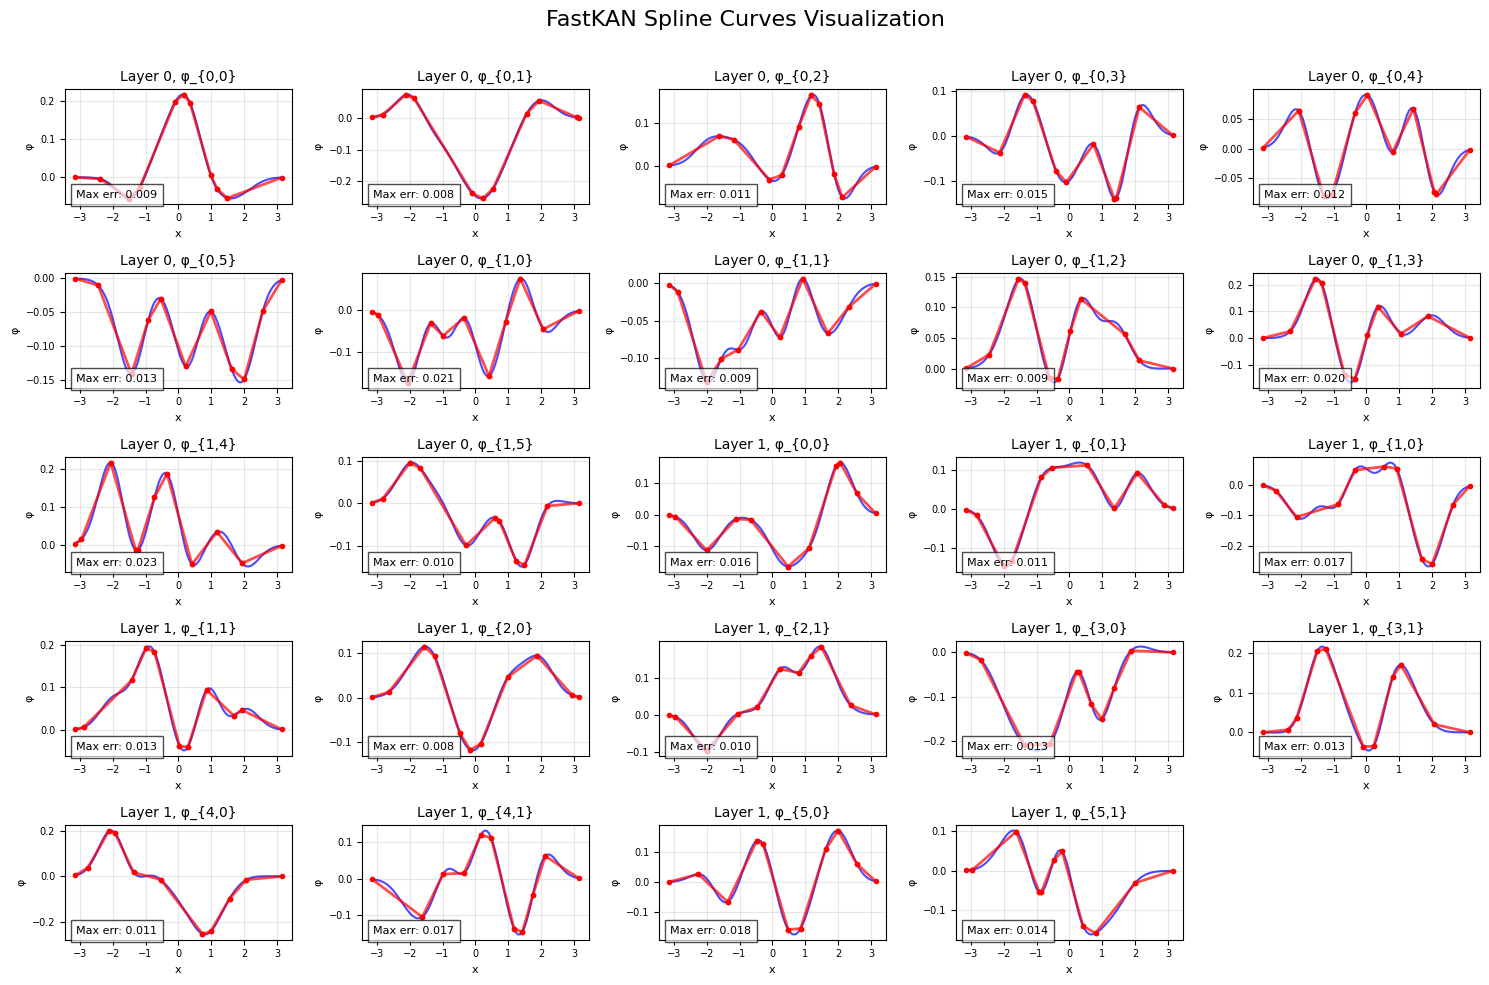

In [6]:
import matplotlib.pyplot as plt
import math
import numpy as np

def fit_kan_vanilla(kan_model, segments_per_curve, min_x=-5.0, max_x=5.0):
    all_segments = []
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        for input_index in range(input_dim):
            for output_index in range(output_dim):
                segments, max_error = find_bspline_segments_given_max_segments(
                    layer, input_index, output_index, segments_per_curve, min_x, max_x
                )
                all_segments.append((
                    layer_idx, 
                    input_index, 
                    output_index, 
                    segments, 
                    max_error
                ))
    return all_segments

def plot_kan(
    kan_model,
    all_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=500,
):
    total_curves = len(all_segments)
    cols = math.ceil(math.sqrt(total_curves))
    rows = math.ceil(total_curves / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    fig.suptitle('FastKAN Spline Curves Visualization', fontsize=16)
    axes = axes.flatten()
    for idx, (layer_idx, input_index, output_index, segments, max_error) in enumerate(all_segments):
        ax = axes[idx]
        layer = kan_model.layers[layer_idx]
        x_tensor, y_tensor = layer.plot_curve(
            input_index, output_index, 
            num_pts=num_pts
        )
        x_orig = x_tensor.detach().cpu().numpy()
        y_orig = y_tensor.detach().cpu().numpy()
        mask = (x_orig >= min_x) & (x_orig <= max_x)
        x_orig = x_orig[mask]
        y_orig = y_orig[mask]
        ax.plot(x_orig, y_orig, 'b-', linewidth=1.5, alpha=0.7, label='Original')
        for x1, x2, slope, intercept in segments:
            x_seg = np.linspace(x1, x2, 50)
            y_seg = slope * x_seg + intercept
            ax.plot(x_seg, y_seg, 'r-', linewidth=2, alpha=0.7)
            ax.plot([x1], [slope * x1 + intercept], 'ro', markersize=3)
            ax.plot([x2], [slope * x2 + intercept], 'ro', markersize=3)
        ax.text(0.05, 0.05, f'Max err: {max_error:.3f}', transform=ax.transAxes, 
                fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
        ax.set_title(f'Layer {layer_idx}, φ_{{{input_index},{output_index}}}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        ax.set_ylabel(f'φ', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.grid(True, alpha=0.3)
    for i in range(total_curves, len(axes)):
        axes[i].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig

kan_model = FastKAN([2, 6, 2])
all_segments = fit_kan_vanilla(
    kan_model,
    min_x=-5.0,
    max_x=5.0,
    segments_per_curve=10
)
fig = plot_kan(
    kan_model,
    all_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=100,
)
plt.show()

# Verification With Lipschitz

![image.png](python_lipschitz.png)

Optimizing segment allocation for plus node at Layer 1, Output 0...
Maximum allowed combined error: 0.3

Dynamic Programming Table (showing minimum error for i splines with j total segments):
Splines (i) / Segments (j)      0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20
0                          0.000    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf
1                            inf  0.250  0.168  0.100  0.049  0.033  0.028  0.027  0.021  0.018  0.011  0.011  0.010  0.008  0.007  0.007  0.006  0.006  0.006  0.005  0.004
2                            inf    inf  0.445  0.364  0.295  0.228  0.177  0.158  0.141  0.091  0.075  0.068  0.058  0.054  0.050  0.046  0.043  0.036  0.032  0.031  0.028
3                            inf    inf    inf  0.559  0.477  0.408  0.342  0.291  0.271  0.255  0.204  0.189  0.17

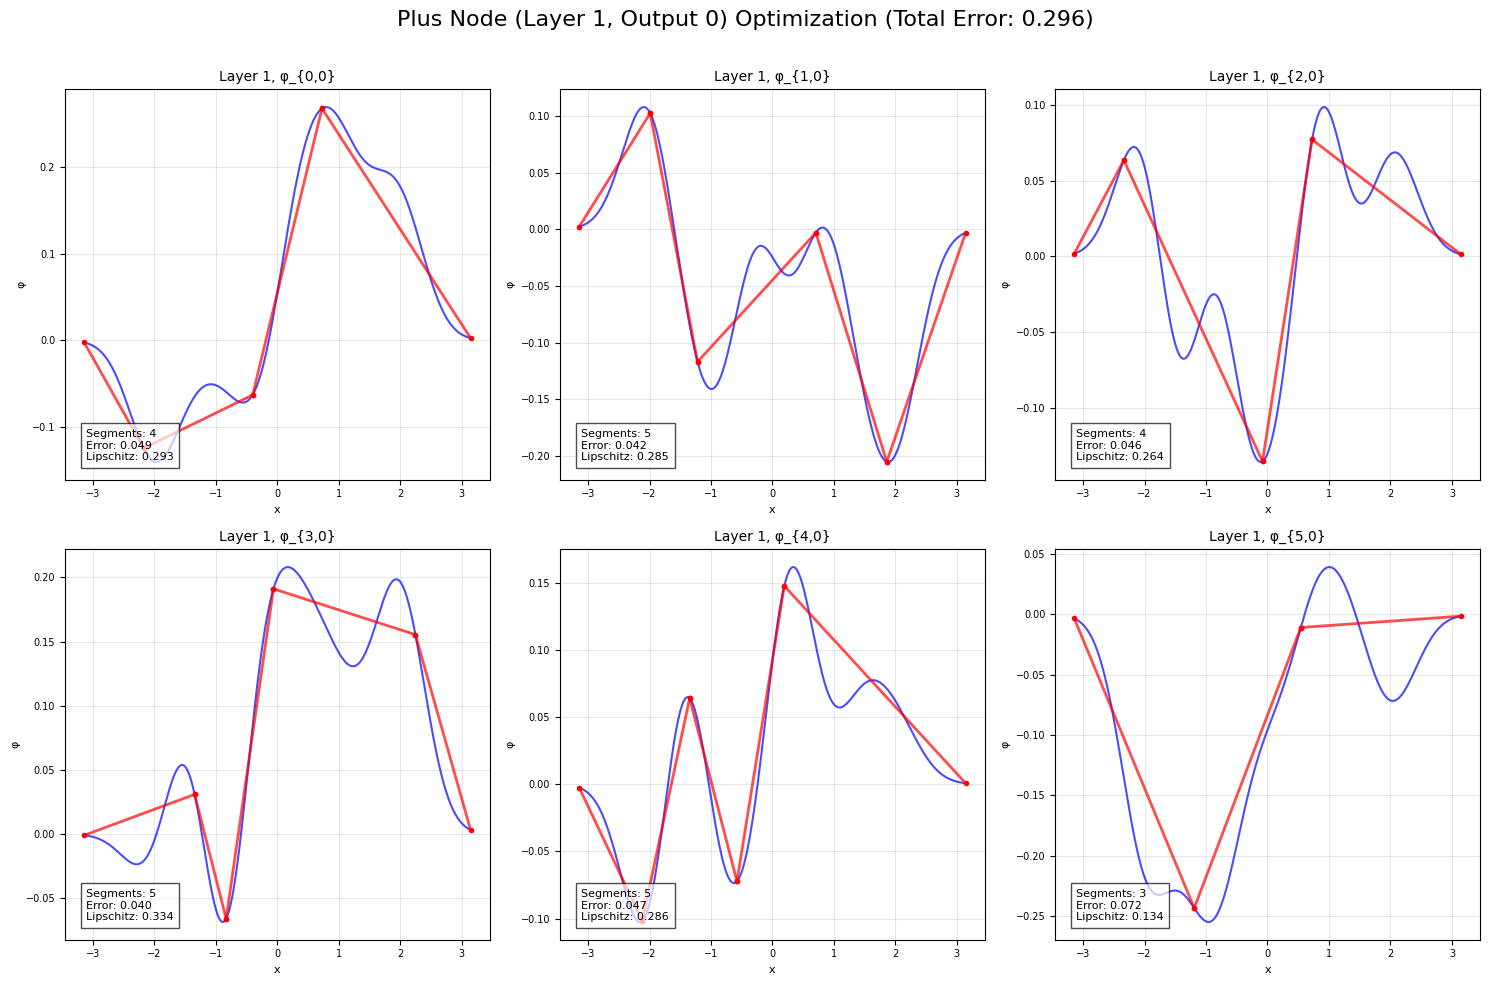

In [24]:
def return_plus_node(kan_model, layer_idx, output_idx):
    """
    Returns a set of all B-splines that feed into a specific plus node.
    
    Args:
        kan_model (FastKAN): The FastKAN model instance
        layer_idx (int): The index of the layer containing the plus node
        output_idx (int): The output index of the plus node in the specified layer
    
    Returns:
        list: A list of tuples in the format (layer_idx, input_idx, output_idx)
            representing all B-splines feeding into the specified plus node
    """
    # Check if the specified layer is valid
    if layer_idx >= len(kan_model.layers):
        raise ValueError(f"Layer index {layer_idx} is out of range. Model has {len(kan_model.layers)} layers.")
    
    # Get the specified layer
    layer = kan_model.layers[layer_idx]
    
    # Check if the specified output index is valid
    if output_idx >= layer.output_dim:
        raise ValueError(f"Output index {output_idx} is out of range. Layer has {layer.output_dim} outputs.")
    
    # For the specified plus node, all B-splines come from the current layer's inputs
    bspline_indices = []
    
    # Each input feature in this layer contributes a set of B-splines to the plus node
    for input_idx in range(layer.input_dim):
        # Each B-spline in the layer is identified by (layer_idx, input_idx, output_idx)
        bspline_indices.append((layer_idx, input_idx, output_idx))
    
    return bspline_indices

def calculate_lipschitz_constant(segments):
    if not segments:
        return 0.0
    
    # The Lipschitz constant is the maximum absolute slope
    lipschitz_constant = 0.0
    
    for x1, x2, slope, intercept in segments:
        lipschitz_constant = max(lipschitz_constant, abs(slope))
    
    return lipschitz_constant

def allocate_single_plus_node(kan_model, layer_idx, output_idx, max_error, min_x=-5.0, max_x=5.0, max_total_segments=100):
    """
    Optimize segment allocation for a single plus node to minimize total segments 
    while keeping the combined error below max_error.
    
    Parameters:
    - kan_model: The FastKAN model
    - layer_idx: The index of the layer containing the plus node
    - output_idx: The output index of the plus node in the specified layer
    - max_error: Maximum combined error allowed
    - min_x, max_x: Range of x values to consider
    - max_total_segments: Maximum total segments to consider
    
    Returns:
    - Dictionary mapping bspline_index to num_segments
    - Total number of segments used
    - Actual combined error achieved
    """
    # Get the B-spline indices feeding into this plus node
    bspline_indices = return_plus_node(kan_model, layer_idx, output_idx)
    
    n_splines = len(bspline_indices)
    
    if n_splines == 0:
        return {}, 0, 0.0  # No splines to optimize
    
    # Calculate error for each B-spline with different segment counts
    all_errors = []
    all_segments = []
    
    # Reasonable max segments per spline
    max_segments_per_spline = min(20, max_total_segments)
    
    for spline_idx, bspline_idx in enumerate(bspline_indices):
        layer_idx, input_idx, output_idx = bspline_idx
        try:
            layer = kan_model.layers[layer_idx]
            
            spline_errors = []
            spline_segments = []
            
            for num_segments in range(1, max_segments_per_spline + 1):
                segments, error = find_bspline_segments_given_max_segments(
                    layer, input_idx, output_idx, num_segments, min_x, max_x
                )
                spline_errors.append(error)
                spline_segments.append(segments)
            
            all_errors.append(spline_errors)
            all_segments.append(spline_segments)
            
        except Exception as e:
            print(f"Error processing spline {bspline_idx}: {e}")
            return {}, 0, float('inf')
    
    # DP table: dp[i][j] = minimum combined error when allocating j segments among first i splines
    dp = [[float('inf')] * (max_total_segments + 1) for _ in range(n_splines + 1)]
    # Base case: 0 splines, 0 segments, 0 error
    dp[0][0] = 0
    
    # Track allocations
    allocation = {}
    
    # Fill the DP table
    for i in range(1, n_splines + 1):
        spline_idx = i - 1
        
        for j in range(1, max_total_segments + 1):  # Start from 1 as we need at least 1 segment
            # Try different segments for current spline
            for s in range(1, min(j + 1, len(all_errors[spline_idx]) + 1)):
                if j - s < 0 or dp[i-1][j-s] == float('inf'):
                    continue
                
                current_error = all_errors[spline_idx][s-1]
                new_error = dp[i-1][j-s] + current_error
                
                if new_error < dp[i][j]:
                    dp[i][j] = new_error
                    allocation[(i, j)] = s
    
    # Print DP table
    print("\nDynamic Programming Table (showing minimum error for i splines with j total segments):")
    print("Splines (i) / Segments (j)".ljust(25), end="")
    
    # Print header row for segment counts
    for j in range(0, min(21, max_total_segments + 1)):  # Limit to 20 columns for readability
        print(f"{j:>7}", end="")
    print()
    
    # Print DP table rows
    for i in range(0, n_splines + 1):
        print(f"{i:<25}", end="")
        for j in range(0, min(21, max_total_segments + 1)):  # Limit to 20 columns for readability
            if dp[i][j] == float('inf'):
                print(f"{'inf':>7}", end="")
            else:
                print(f"{dp[i][j]:.3f}".rjust(7), end="")
        print()
    
    # Print allocation table
    print("\nAllocation Table (segments allocated to spline i when using j total segments):")
    print("Splines (i) / Segments (j)".ljust(25), end="")
    
    # Print header row for segment counts
    for j in range(1, min(21, max_total_segments + 1)):  # Start from 1, limit to 20 columns
        print(f"{j:>7}", end="")
    print()
    
    # Print allocation table rows
    for i in range(1, n_splines + 1):
        print(f"{i:<25}", end="")
        for j in range(1, min(21, max_total_segments + 1)):  # Start from 1, limit to 20 columns
            s = allocation.get((i, j), 0)
            print(f"{s:>7}", end="")
        print()
    
    # Find minimum segments needed for error <= max_error
    min_segments = float('inf')
    for j in range(n_splines, max_total_segments + 1):  # Start from n_splines as we need at least 1 segment per spline
        if dp[n_splines][j] <= max_error and j < min_segments:
            min_segments = j
    
    if min_segments == float('inf'):
        return {}, 0, float('inf')  # No solution found within constraints
    
    # Reconstruct the allocation
    result_allocation = {}
    remaining_segments = min_segments
    
    # Print the chosen allocation path
    print("\nChosen Allocation Path (for error <= max_error):")
    print(f"Total segments: {min_segments}, Total error: {dp[n_splines][min_segments]:.4f}")
    
    for i in range(n_splines, 0, -1):
        s = allocation.get((i, remaining_segments), 0)
        spline_idx = i - 1
        bspline_idx = bspline_indices[spline_idx]
        
        if s > 0:  # Should always be true since we allocated at least 1 segment per spline
            # Store the allocation using the original bspline index tuple
            result_allocation[bspline_idx] = s
            print(f"Spline {i} (Layer {bspline_idx[0]}, Input {bspline_idx[1]}, Output {bspline_idx[2]}): {s} segments, remaining: {remaining_segments - s}")
        
        remaining_segments -= s
    
    total_error = dp[n_splines][min_segments]
    
    return result_allocation, min_segments, total_error

def visualize_optimized_allocation(kan_model, layer_idx, output_idx, allocation, total_error, 
                                  min_x=-5.0, max_x=5.0, figsize=(15, 10)):
    """
    Visualize the optimized B-spline approximations for a specific plus node.
    
    Parameters:
    - kan_model: The FastKAN model
    - layer_idx: The index of the layer containing the plus node
    - output_idx: The output index of the plus node in the specified layer
    - allocation: Dictionary mapping bspline_index to num_segments
    - total_error: The total error of the allocation
    - min_x, max_x: Range of x values to consider
    - figsize: Size of the figure
    """
    # Get the B-spline indices feeding into this plus node
    bspline_indices = return_plus_node(kan_model, layer_idx, output_idx)
    
    # Count the number of splines to visualize
    n_splines = len(bspline_indices)
    cols = min(3, n_splines)
    rows = (n_splines + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    fig.suptitle(f'Plus Node (Layer {layer_idx}, Output {output_idx}) Optimization (Total Error: {total_error:.3f})', fontsize=16)
    
    axes = axes.flatten()
    
    for i, bspline_idx in enumerate(bspline_indices):
        if i >= len(axes):
            break
            
        l_idx, input_idx, out_idx = bspline_idx
        num_segments = allocation.get(bspline_idx, 0)
        
        ax = axes[i]
        
        # Get the original B-spline curve
        layer = kan_model.layers[l_idx]
        x_tensor, y_tensor = layer.plot_curve(
            input_idx, out_idx, 
            num_pts=500
        )
        
        x_orig = x_tensor.detach().cpu().numpy()
        y_orig = y_tensor.detach().cpu().numpy()
        
        # Filter to desired range
        mask = (x_orig >= min_x) & (x_orig <= max_x)
        x_orig = x_orig[mask]
        y_orig = y_orig[mask]
        
        # Plot original curve
        ax.plot(x_orig, y_orig, 'b-', linewidth=1.5, alpha=0.7, label='Original')
        
        # Get the optimized segments
        segments, error = find_bspline_segments_given_max_segments(
            layer, input_idx, out_idx, num_segments, min_x, max_x
        )
        
        # Calculate Lipschitz constant
        lipschitz_constant = calculate_lipschitz_constant(segments)
        
        # Plot optimized segments
        for x1, x2, slope, intercept in segments:
            x_seg = np.linspace(x1, x2, 50)
            y_seg = slope * x_seg + intercept
            ax.plot(x_seg, y_seg, 'r-', linewidth=2, alpha=0.7)
            ax.plot([x1], [slope * x1 + intercept], 'ro', markersize=3)
            ax.plot([x2], [slope * x2 + intercept], 'ro', markersize=3)
        
        # Add text with segments, error, and Lipschitz constant
        ax.text(0.05, 0.05, 
                f'Segments: {num_segments}\nError: {error:.3f}\nLipschitz: {lipschitz_constant:.3f}', 
                transform=ax.transAxes, fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.7))
        
        ax.set_title(f'Layer {l_idx}, φ_{{{input_idx},{out_idx}}}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        ax.set_ylabel(f'φ', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(n_splines, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig

def run_optimization_example():
    # Create a FastKAN model
    kan_model = FastKAN([2, 6, 2])
    
    # Define the range of x values to consider
    min_x = -5.0
    max_x = 5.0
    
    # Select a plus node to optimize
    # Format: layer_idx, output_idx
    layer_idx = 1
    output_idx = 0
    
    # Set the maximum allowed combined error
    max_error = 0.3
    
    print(f"Optimizing segment allocation for plus node at Layer {layer_idx}, Output {output_idx}...")
    print(f"Maximum allowed combined error: {max_error}")
    
    # Run the optimization
    allocation, total_segments, total_error = allocate_single_plus_node(
        kan_model=kan_model,
        layer_idx=layer_idx,
        output_idx=output_idx,
        max_error=max_error,
        min_x=min_x,
        max_x=max_x,
        max_total_segments=50
    )
    
    # Get the B-spline indices for reporting
    bspline_indices = return_plus_node(kan_model, layer_idx, output_idx)
    
    # Print the results
    print("\nOptimization Results:")
    print(f"Total segments used: {total_segments}")
    print(f"Actual combined error: {total_error:.4f}")
    print(f"Number of B-splines: {len(bspline_indices)}")
    print("\nSegment allocation:")
    
    for bspline_idx, num_segments in allocation.items():
        l_idx, input_idx, out_idx = bspline_idx
        print(f"  Layer {l_idx}, Input {input_idx}, Output {out_idx}: {num_segments} segments")
    
    # Visualize the results
    fig = visualize_optimized_allocation(
        kan_model=kan_model,
        layer_idx=layer_idx,
        output_idx=output_idx,
        allocation=allocation,
        total_error=total_error,
        min_x=min_x,
        max_x=max_x
    )
    
    plt.show()
    
    return allocation, total_segments, total_error

# Execute the example if run directly
if __name__ == "__main__":
    allocation, total_segments, total_error = run_optimization_example()

In [ ]:
def find_plus_node_feeding_into_bspline(kan_model, bspline_idx):
    """
    Returns the plus node that feeds into a specific B-spline.
    
    Args:
        kan_model (FastKAN): The FastKAN model instance
        bspline_layer_idx (int): The index of the layer containing the B-spline
        input_idx (int): The input index of the B-spline in the specified layer
        output_idx (int): The output index of the B-spline in the specified layer
    
    Returns:
        tuple: A tuple in the format (layer_idx, node_idx) representing the plus node
            that feeds into the specified B-spline, or None if no such plus node exists
            (e.g., for B-splines in the first layer)
    
    Raises:
        ValueError: If the specified indices are out of range
    """
    # Check if the B-spline is in the first layer (no plus node feeds into it)
    bspline_layer_idx, input_idx, output_idx = bspline_idx[0], bspline_idx[1], bspline_idx[2]
    if bspline_layer_idx == 0:
        return None
    
    # Check if the specified layer is valid
    if bspline_layer_idx >= len(kan_model.layers):
        raise ValueError(f"Layer index {bspline_layer_idx} is out of range. Model has {len(kan_model.layers)} layers.")
    
    # Get the specified layer
    current_layer = kan_model.layers[bspline_layer_idx]
    
    # Check if the specified input and output indices are valid
    if input_idx >= current_layer.input_dim:
        raise ValueError(f"Input index {input_idx} is out of range. Layer has {current_layer.input_dim} inputs.")
    if output_idx >= current_layer.output_dim:
        raise ValueError(f"Output index {output_idx} is out of range. Layer has {current_layer.output_dim} outputs.")
    
    # The previous layer contains the plus node that feeds into this B-spline
    previous_layer_idx = bspline_layer_idx - 1
    previous_layer = kan_model.layers[previous_layer_idx]
    
    # The input_idx of the B-spline corresponds to which output node from the previous layer
    # is feeding into this B-spline
    plus_node_idx = input_idx
    
    # Verify that this plus node exists in the previous layer
    if plus_node_idx >= previous_layer.output_dim:
        raise ValueError(f"Calculated plus node index {plus_node_idx} is out of range. Previous layer has {previous_layer.output_dim} outputs.")
    
    return (previous_layer_idx, plus_node_idx)

def allocate_single_plus_node(kan_model, layer_idx, output_idx, min_x=-5.0, max_x=5.0, max_total_segments=100, previous_dp_tables=None):
    """
    Analyze segment allocation for a plus node and return two DP tables:
    1. Error table - Error for each combination of B-splines and segment counts
    2. Allocation table - Optimal segment allocation for each B-spline
    
    Parameters:
    - kan_model: The FastKAN model
    - layer_idx: The index of the layer containing the plus node
    - output_idx: The output index of the plus node in the specified layer
    - min_x, max_x: Range of x values to consider
    - max_total_segments: Maximum total segments to consider
    - previous_dp_tables: Dictionary of error tables for plus nodes we've already computed
                            Keys are tuples (layer_idx, input_idx)
    
    Returns:
    - error_table: 2D list with B-splines on y-axis and segment count on x-axis, containing error values
    - allocation_table: 2D list with B-splines on y-axis and segment count on x-axis, containing optimal allocations
    """
    # Get the B-splines that feed into this plus node
    bspline_indices = return_plus_node(kan_model, layer_idx, output_idx)
    
    n_splines = len(bspline_indices)
    
    if n_splines == 0:
        return [], []  # No splines to analyze
    
    # Calculate error for each B-spline with different segment counts
    all_errors = []
    all_segments = []
    
    # Reasonable max segments per spline
    max_segments_per_spline = min(20, max_total_segments)

        # Check if any B-splines have pre-computed tables feeding into them
    if previous_dp_tables is not None:
        for spline_idx, bspline_idx in enumerate(bspline_indices):
            plus_node_idx = find_plus_node_feeding_into_bspline(kan_model, bspline_idx)
            if plus_node_idx in previous_dp_tables:
                print(f"Found pre-computed table feeding into B-spline {bspline_idx}")
    
    for spline_idx, bspline_idx in enumerate(bspline_indices):
        layer_idx, input_idx, output_idx = bspline_idx
        try:
            layer = kan_model.layers[layer_idx]
            
            spline_errors = []
            spline_segments = []
            
            for num_segments in range(1, max_segments_per_spline + 1):
                segments, error = find_bspline_segments_given_max_segments(
                    layer, input_idx, output_idx, num_segments, min_x, max_x
                )
                lipschitz_constant = calculate_lipschitz_constant(segments)
                spline_errors.append(error)
                spline_segments.append(segments)
            
            all_errors.append(spline_errors)
            all_segments.append(spline_segments)
            
        except Exception as e:
            print(f"Error processing spline {bspline_idx}: {e}")
            return [], []
    
    # DP table: dp[i][j] = minimum combined error when allocating j segments among first i splines
    dp = [[float('inf')] * (max_total_segments + 1) for _ in range(n_splines + 1)]
    # Base case: 0 splines, 0 segments, 0 error
    dp[0][0] = 0
    
    # Track allocations
    allocation = {}
    
    # Fill the DP table
    for i in range(1, n_splines + 1):
        spline_idx = i - 1
        
        for j in range(1, max_total_segments + 1):  # Start from 1 as we need at least 1 segment
            # Try different segments for current spline
            for s in range(1, min(j + 1, len(all_errors[spline_idx]) + 1)):
                if j - s < 0 or dp[i-1][j-s] == float('inf'):
                    continue
                
                current_error = all_errors[spline_idx][s-1]
                new_error = max(dp[i-1][j-s], current_error)  # Use max error for minimax objective
                
                if new_error < dp[i][j]:
                    dp[i][j] = new_error
                    allocation[(i, j)] = s
    
    # Create error table: B-splines (rows) x Segment counts (columns)
    error_table = []
    
    # Add header row with segment counts
    header_row = ["B-spline \\ Segments"]
    for j in range(1, max_total_segments + 1):
        header_row.append(j)
    error_table.append(header_row)
    
    # Add error values for each B-spline and segment count
    for i in range(1, n_splines + 1):
        row = [f"B-spline {i}"]
        for j in range(1, max_total_segments + 1):
            if dp[i][j] == float('inf'):
                row.append("inf")
            else:
                row.append(round(dp[i][j], 4))
        error_table.append(row)
    
    # Create allocation table: B-splines (rows) x Segment counts (columns)
    allocation_table = []
    
    # Add header row with segment counts
    allocation_table.append(header_row)  # Reuse the same header row
    
    # Add allocation values for each B-spline and segment count
    for i in range(1, n_splines + 1):
        row = [f"B-spline {i}"]
        for j in range(1, max_total_segments + 1):
            row.append(allocation.get((i, j), 0))
        allocation_table.append(row)
    
    return error_table, allocation_table

Error Table:
['B-spline \\ Segments', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
['B-spline 1', np.float64(0.2399), np.float64(0.1341), np.float64(0.1176), np.float64(0.0657), np.float64(0.0542), np.float64(0.0303), np.float64(0.0234), np.float64(0.0216), np.float64(0.0157), np.float64(0.014)]
['B-spline 2', 'inf', np.float64(0.2399), np.float64(0.1341), np.float64(0.1176), np.float64(0.0841), np.float64(0.0841), np.float64(0.0657), np.float64(0.0542), np.float64(0.0343), np.float64(0.0303)]
['B-spline 3', 'inf', 'inf', np.float64(0.2399), np.float64(0.1341), np.float64(0.1176), np.float64(0.1012), np.float64(0.0887), np.float64(0.0841), np.float64(0.0841), np.float64(0.083)]
['B-spline 4', 'inf', 'inf', 'inf', np.float64(0.2462), np.float64(0.2399), np.float64(0.2247), np.float64(0.1635), np.float64(0.1397), np.float64(0.1341), np.float64(0.1176)]
['B-spline 5', 'inf', 'inf', 'inf', 'inf', np.float64(0.2462), np.float64(0.2399), np.float64(0.2247), np.float64(0.1674), np.float64(0.1635), np.float

([['B-spline \\ Segments', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  ['B-spline 1',
   np.float64(0.2399),
   np.float64(0.1341),
   np.float64(0.1176),
   np.float64(0.0657),
   np.float64(0.0542),
   np.float64(0.0303),
   np.float64(0.0234),
   np.float64(0.0216),
   np.float64(0.0157),
   np.float64(0.014)],
  ['B-spline 2',
   'inf',
   np.float64(0.2399),
   np.float64(0.1341),
   np.float64(0.1176),
   np.float64(0.0841),
   np.float64(0.0841),
   np.float64(0.0657),
   np.float64(0.0542),
   np.float64(0.0343),
   np.float64(0.0303)],
  ['B-spline 3',
   'inf',
   'inf',
   np.float64(0.2399),
   np.float64(0.1341),
   np.float64(0.1176),
   np.float64(0.1012),
   np.float64(0.0887),
   np.float64(0.0841),
   np.float64(0.0841),
   np.float64(0.083)],
  ['B-spline 4',
   'inf',
   'inf',
   'inf',
   np.float64(0.2462),
   np.float64(0.2399),
   np.float64(0.2247),
   np.float64(0.1635),
   np.float64(0.1397),
   np.float64(0.1341),
   np.float64(0.1176)],
  ['B-spline 5',
   'inf',
  

def fit_kan_lipschitz():
    for plus_node in KAN:
        allocate_single_plus_node(plus_node, all_previous_dp_tables)

Make allocate_single_plus_node take in a new variable called all_previous_dp_tables. all_previous_dp_tables contains the error table we have computed for each bspline up until this point. It's an array of error tables where the bspline



def fit_kan_lipschitz():
   1. Get allocate_single_plus_node() to actually take in a plus node and return DP table
   2. Once we have this we’ll have a dynamic programming table for each set of bsplines. Which tells us if you allocate a certain number of segments then this addition node will return this error
   2. Make allocate_single_plus_node take in a new variable all_previous_dp_tables. Ex. The function will make a new table which will have number of segments on x axis and spline number on y-axis. It will get the 2 bsplines associated with the plus node. Lets look at trying to fill in cell with allocation of 5 segments at bspline 1. We will try the 

   3. Then these will feed into another 2 b-splines. which feed into Layer 2: plus node 1 and plus node 2
      For plus node 1:
        Create a dynamic programming table which has the 3 bsplines that feed into it on y axis and number of segments on x axis.

Questions:
The way I have this setup, each layer will have to take in a bigger and bigger max_segments budget

# Verification With Sampling

![image.png](python_sampling.png)

Dynamic Programming Table for first B-spline (input=0, output=0):
----------------------------------------------------------------------
Num Segments | Max Error | Segments
----------------------------------------------------------------------
           1 | 0.2155    | 1
           2 | 0.1869    | 2
           3 | 0.0887    | 3
           4 | 0.0378    | 4
           5 | 0.0297    | 5
           6 | 0.0250    | 6
           7 | 0.0188    | 7
           8 | 0.0135    | 8
           9 | 0.0141    | 9
          10 | 0.0087    | 10
          11 | 0.0086    | 11
          12 | 0.0071    | 12
          13 | 0.0071    | 13
          14 | 0.0062    | 14
          15 | 0.0051    | 15
          16 | 0.0043    | 16
          17 | 0.0040    | 17
          18 | 0.0039    | 18
          19 | 0.0038    | 19
          20 | 0.0038    | 20

Detailed segment information for selected segmentations:

For 1 segments (max error = 0.2155):
  Segment | Start x | End x   | Slope     | Intercept
  -------------

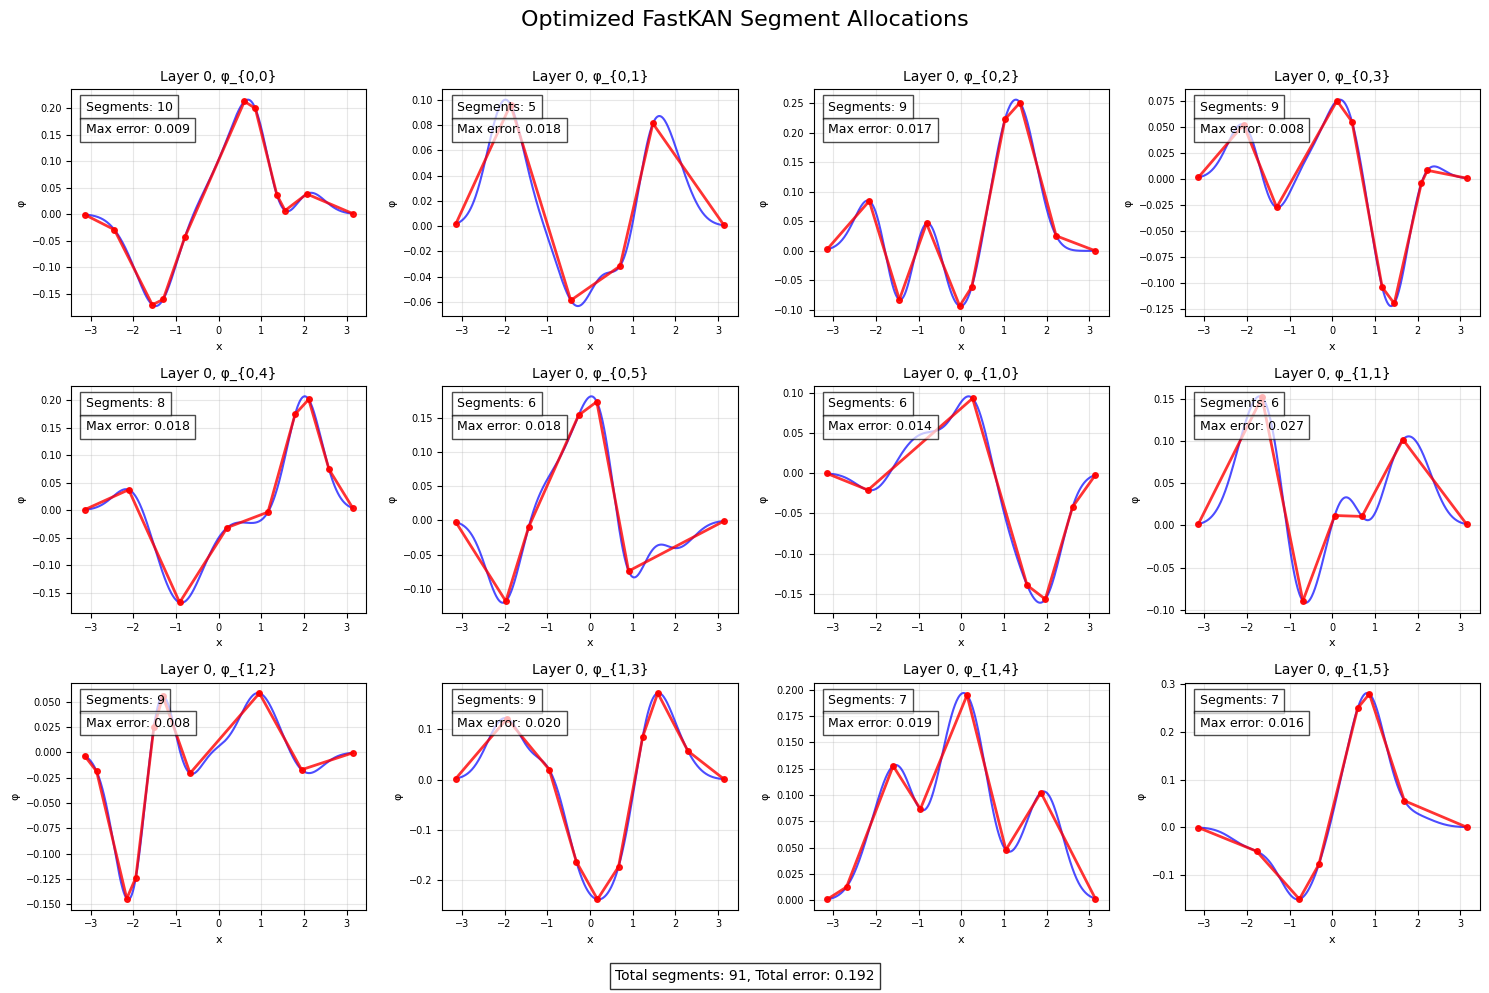

In [ ]:
def create_bspline_dp_table_sampling(kan_model, min_x=-5.0, max_x=5.0, max_segments=15, show_first_dp=True):
    layer = kan_model.layers[0]
    input_dim = layer.input_dim
    output_dim = layer.output_dim
    n_samples = 1000
    results = {}
    
    # Flag to track if we've already displayed the first DP table
    first_dp_displayed = False
    
    # For each input-output pair in the layer
    for input_index in range(input_dim):
        for output_index in range(output_dim):
            # Key for this specific b-spline
            key = f"layer0_in{input_index}_out{output_index}"
            results[key] = {"segments": [], "errors": []}
            
            # Get the original b-spline output
            x_tensor, y_tensor = layer.plot_curve(
                input_index, output_index, 
                num_pts=n_samples
            )
            
            # Convert to numpy for faster processing
            x_np = x_tensor.detach().cpu().numpy()
            y_np = y_tensor.detach().cpu().numpy()
            
            # Filter to desired range
            mask = (x_np >= min_x) & (x_np <= max_x)
            x_np = x_np[mask]
            y_np = y_np[mask]
            
            # Create a DP table for this b-spline
            dp_table = []
            
            # Try different segment counts
            for num_segments in range(1, max_segments + 1):
                # Find the optimal segments for this count
                segments, error = find_bspline_segments_given_max_segments(
                    layer, input_index, output_index, num_segments, min_x, max_x
                )
                
                # If no valid segments were found, use infinity as the error
                if not segments:
                    dp_table.append(float('inf'))
                    results[key]["segments"].append([])
                    results[key]["errors"].append(float('inf'))
                    continue
                
                # Apply the piecewise linear approximation to the sample points
                y_approx = np.zeros_like(y_np)
                
                # Vectorized approach to find which segment each x value belongs to
                for x1, x2, slope, intercept in segments:
                    # Create a mask for points in this segment
                    segment_mask = (x_np >= x1) & (x_np <= x2)
                    # Apply the linear function to these points
                    y_approx[segment_mask] = slope * x_np[segment_mask] + intercept
                
                # Calculate maximum approximation error
                max_error = np.max(np.abs(y_np - y_approx))
                
                # Store results
                dp_table.append(max_error)
                results[key]["segments"].append(segments)
                results[key]["errors"].append(max_error)
            
            # Add the DP table to the results
            results[key]["dp_table"] = dp_table
            
            # Display the DP table for the first processed B-spline
            if show_first_dp and not first_dp_displayed:
                print(f"Dynamic Programming Table for first B-spline (input={input_index}, output={output_index}):")
                print("-" * 70)
                print("Num Segments | Max Error | Segments")
                print("-" * 70)
                
                for seg_idx in range(len(dp_table)):
                    num_segments = seg_idx + 1
                    error = dp_table[seg_idx]
                    segments_count = len(results[key]["segments"][seg_idx]) if results[key]["segments"][seg_idx] else 0
                    
                    # Format error to handle infinity
                    error_str = f"{error:.4f}" if error != float('inf') else "inf"
                    
                    # Print summary for this number of segments
                    print(f"{num_segments:12} | {error_str:9} | {segments_count}")
                
                # Print the actual segment details for some selected numbers of segments
                print("\nDetailed segment information for selected segmentations:")
                
                # Choose a few representative segment counts to display details for
                segment_counts_to_show = [1, 3, max_segments] if max_segments > 3 else range(1, max_segments+1)
                
                for seg_count in segment_counts_to_show:
                    idx = seg_count - 1
                    if idx < len(results[key]["segments"]):
                        segments = results[key]["segments"][idx]
                        error = results[key]["errors"][idx]
                        error_str = f"{error:.4f}" if error != float('inf') else "inf"
                        
                        print(f"\nFor {seg_count} segments (max error = {error_str}):")
                        if not segments:
                            print("  No valid segmentation found")
                        else:
                            print("  Segment | Start x | End x   | Slope     | Intercept")
                            print("  " + "-" * 58)
                            for i, (x1, x2, slope, intercept) in enumerate(segments):
                                print(f"  {i+1:7} | {x1:7.3f} | {x2:7.3f} | {slope:9.4f} | {intercept:9.4f}")
                
                # Mark that we've displayed the first DP table
                first_dp_displayed = True
    
    return results

def fit_layer_1_sampling(kan_model, min_x=-5.0, max_x=5.0, max_error_layer_1=0.5):
    """
    Optimally allocate segments to B-splines in layer 1 to minimize total segments while keeping error below max_error_layer_1.
    
    Args:
        kan_model: The FastKAN model
        min_x: Minimum x value for the domain
        max_x: Maximum x value for the domain
        max_error_layer_1: Maximum error allowed for layer 1
        
    Returns:
        List of tuples with (layer_idx, input_index, output_index, segments, max_error)
    """
    # Step 1: Create the DP tables for layer 1's B-splines
    dp_results = create_bspline_dp_table_sampling(kan_model, min_x, max_x, max_segments=20)  # Use up to 20 segments per spline
    
    # Step 2: Extract the layer 1 B-splines and their errors
    layer = kan_model.layers[0]
    input_dim = layer.input_dim
    output_dim = layer.output_dim
    
    # Store each B-spline's error information
    splines = []
    for input_index in range(input_dim):
        for output_index in range(output_dim):
            key = f"layer0_in{input_index}_out{output_index}"
            splines.append({
                'key': key,
                'input_index': input_index,
                'output_index': output_index,
                'errors': dp_results[key]['errors'],
                'segments': dp_results[key]['segments']
            })
    
    # Step 3: Use DP to find the optimal segment allocation
    
    # Initialize the DP table
    # dp[i][e] = minimum total segments needed to approximate the first i splines
    # with a total error of at most e
    n_splines = len(splines)
    
    # Discretize the error space for DP
    error_precision = 100  # Number of discrete error levels
    max_error_discrete = int(max_error_layer_1 * error_precision)
    
    # Initialize DP table with infinity
    dp = {}
    backtrack = {}
    
    # Base case: 0 splines, 0 error, 0 segments
    dp[(0, 0)] = 0
    
    # Print header for the DP table
    print("\n" + "="*80)
    print("DYNAMIC PROGRAMMING TABLE FOR SEGMENT ALLOCATION")
    print("="*80)
    print("Notation: dp[spline_idx, error] = total_segments")
    print("-"*80)
    
    # Initialize a tracking dictionary to collect entries for a readable table
    dp_entries = {}
    
    # Fill the DP table
    for i in range(n_splines):
        spline = splines[i]
        spline_key = f"in{spline['input_index']}_out{spline['output_index']}"
        
        print(f"\nProcessing spline {i+1}/{n_splines}: {spline_key}")
        
        # Track entries for this spline
        spline_entries = []
        
        for prev_err in range(max_error_discrete + 1):
            if (i, prev_err) not in dp:
                continue
                
            for segments_idx in range(len(spline['errors'])):
                error = spline['errors'][segments_idx]
                num_segments = len(spline['segments'][segments_idx])
                
                if error == float('inf'):
                    continue  # Skip invalid segment counts
                
                # Calculate new discretized error
                new_err_discrete = prev_err + int(error * error_precision)
                
                # Skip if we exceed the maximum error
                if new_err_discrete > max_error_discrete:
                    continue
                
                # Calculate total segments with this allocation
                total_segments = dp[(i, prev_err)] + num_segments
                
                # Update DP if this is better than existing solution
                if (i+1, new_err_discrete) not in dp or total_segments < dp[(i+1, new_err_discrete)]:
                    dp[(i+1, new_err_discrete)] = total_segments
                    backtrack[(i+1, new_err_discrete)] = (i, prev_err, segments_idx + 1)  # +1 because segments_idx is 0-based
                    
                    # Add entry to our tracking dictionary for the formatted table
                    spline_entries.append({
                        'prev_error': prev_err / error_precision,
                        'new_error': new_err_discrete / error_precision,
                        'segments_added': num_segments,
                        'total_segments': total_segments,
                        'segment_error': error
                    })
        
        # Sort and display the entries for this spline
        if spline_entries:
            spline_entries.sort(key=lambda x: x['total_segments'])
            print(f"  Selected DP entries for spline {spline_key}:")
            print("  " + "-"*70)
            print("  {:^12} | {:^12} | {:^12} | {:^12} | {:^12}".format(
                "Prev Error", "Segments", "Seg Error", "New Error", "Total Segs"))
            print("  " + "-"*70)
            
            # Show at most 10 entries for readability
            for entry in spline_entries[:10]:
                print("  {:12.4f} | {:12d} | {:12.4f} | {:12.4f} | {:12d}".format(
                    entry['prev_error'], 
                    entry['segments_added'],
                    entry['segment_error'],
                    entry['new_error'],
                    entry['total_segments']))
            
            # If there are more entries, show this
            if len(spline_entries) > 10:
                print(f"  ... and {len(spline_entries) - 10} more entries")
        else:
            print("  No valid DP entries for this spline")
    
    # Step 4: Find the optimal solution that minimizes total segments
    min_segments = float('inf')
    best_state = None
    
    print("\n" + "="*50)
    print("FINAL SOLUTION CANDIDATES")
    print("="*50)
    print("{:^12} | {:^12} | {:^12}".format("Error", "Total Segments", "State"))
    print("-"*50)
    
    # Sort and display the final states by total segments
    final_states = []
    for err in range(max_error_discrete + 1):
        if (n_splines, err) in dp:
            total_segs = dp[(n_splines, err)]
            final_states.append((err / error_precision, total_segs, (n_splines, err)))
            if total_segs < min_segments:
                min_segments = total_segs
                best_state = (n_splines, err)
    
    # Sort and print the final states
    final_states.sort(key=lambda x: x[1])  # Sort by total segments
    for error, segments, state in final_states[:15]:  # Show top 15 solutions
        is_best = "✓" if state == best_state else " "
        print("{:12.4f} | {:12d} | {:12s} {}".format(
            error, segments, f"({state[0]}, {state[1]})", is_best))
    
    if len(final_states) > 15:
        print(f"... and {len(final_states) - 15} more solutions")
    
    # Step 5: Backtrack to find the segment allocation
    if best_state is None:
        print("\nNo valid solution found!")
        return []  # No valid solution found
    
    print("\n" + "="*70)
    print(f"OPTIMAL SOLUTION: {min_segments} segments with error {best_state[1]/error_precision:.4f}")
    print("="*70)
    
    # Print the backtracking process
    print("\nBacktracking to find optimal allocation:")
    print("{:<5} | {:<12} | {:<12} | {:<12} | {:<12}".format(
        "Step", "Spline", "Prev State", "Segments", "Error"))
    print("-"*70)
    
    allocation = []
    curr_state = best_state
    step_count = 1
    
    while curr_state in backtrack:
        prev_i, prev_err, segments_count = backtrack[curr_state]
        spline_idx = prev_i
        spline = splines[spline_idx]
        
        # Get the actual segments and error
        seg_idx = segments_count - 1  # Convert back to 0-based index
        actual_error = spline['errors'][seg_idx]
        num_segments = len(spline['segments'][seg_idx])
        
        spline_key = f"in{spline['input_index']}_out{spline['output_index']}"
        
        print("{:<5} | {:<12} | {:<12} | {:<12} | {:<12.4f}".format(
            step_count, 
            spline_key, 
            f"({prev_i}, {prev_err})",
            num_segments,
            actual_error
        ))
        
        allocation.append((
            spline['input_index'],
            spline['output_index'],
            seg_idx
        ))
        
        curr_state = (prev_i, prev_err)
        step_count += 1
    
    # Reverse to get the correct order
    allocation.reverse()
    
    # Step 6: Convert allocation to the expected output format
    all_segments = []
    total_error = 0
    
    for input_index, output_index, segments_idx in allocation:
        key = f"layer0_in{input_index}_out{output_index}"
        segments = dp_results[key]['segments'][segments_idx]
        error = dp_results[key]['errors'][segments_idx]
        
        all_segments.append((
            0,  # layer_idx = 0 for layer 1
            input_index,
            output_index,
            segments,
            error
        ))
        
        total_error += error
    
    print(f"\nOptimized layer 1 with {min_segments} total segments and total error {total_error:.4f}")
    return all_segments

def plot_optimized_kan(
    kan_model,
    optimized_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=500,
    show_knot_points=True,
    show_error=True,
    color_original='blue',
    color_segments='red',
    color_knots='red',
    alpha_original=0.7,
    alpha_segments=0.8,
    save_path=None
):
    """
    optimized_segments: List of tuples (layer_idx, input_index, output_index, segments, max_error)
    """
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Count total B-splines to plot
    total_curves = len(optimized_segments)
    if total_curves == 0:
        return plt.figure(figsize=(6, 4))  # Return empty figure if no segments
    
    # Calculate grid layout
    cols = math.ceil(math.sqrt(total_curves))
    rows = math.ceil(total_curves / cols)
    
    # Create figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    fig.suptitle('Optimized FastKAN Segment Allocations', fontsize=16)
    axes = axes.flatten()
    
    # Total segment count for statistics
    total_segment_count = 0
    total_error = 0.0
    
    # Plot each B-spline
    for idx, (layer_idx, input_index, output_index, segments, max_error) in enumerate(optimized_segments):
        if idx >= len(axes):
            break  # Safety check
            
        ax = axes[idx]
        layer = kan_model.layers[layer_idx]
        
        # Get the original B-spline curve
        x_tensor, y_tensor = layer.plot_curve(
            input_index, output_index, 
            num_pts=num_pts
        )
        
        # Convert to numpy arrays
        x_orig = x_tensor.detach().cpu().numpy()
        y_orig = y_tensor.detach().cpu().numpy()
        
        # Filter to desired range
        mask = (x_orig >= min_x) & (x_orig <= max_x)
        x_orig = x_orig[mask]
        y_orig = y_orig[mask]
        
        # Plot original curve
        ax.plot(x_orig, y_orig, '-', color=color_original, linewidth=1.5, 
                alpha=alpha_original, label='Original B-spline')
        
        # Count segments and gather knot points for this B-spline
        segment_count = len(segments)
        total_segment_count += segment_count
        knot_points_x = []
        knot_points_y = []
        
        # Plot each linear segment
        for x1, x2, slope, intercept in segments:
            # Generate points along this segment
            x_seg = np.linspace(x1, x2, 50)
            y_seg = slope * x_seg + intercept
            
            # Plot the segment
            ax.plot(x_seg, y_seg, '-', color=color_segments, linewidth=2, alpha=alpha_segments)
            
            # Add knot points
            knot_points_x.extend([x1, x2])
            knot_points_y.extend([slope * x1 + intercept, slope * x2 + intercept])
        
        # Plot knot points if requested
        if show_knot_points and knot_points_x:
            # Remove duplicates (where segments connect)
            unique_points = {}
            for x, y in zip(knot_points_x, knot_points_y):
                # Round to avoid floating-point issues
                key = round(x, 6)
                unique_points[key] = y
                
            unique_x = list(unique_points.keys())
            unique_y = list(unique_points.values())
            
            ax.plot(unique_x, unique_y, 'o', color=color_knots, markersize=4, alpha=0.9)
        
        # Display error and segment count
        if show_error:
            ax.text(0.05, 0.95, f'Segments: {segment_count}', transform=ax.transAxes, 
                    fontsize=9, bbox=dict(facecolor='white', alpha=0.7), 
                    verticalalignment='top')
            ax.text(0.05, 0.85, f'Max error: {max_error:.3f}', transform=ax.transAxes, 
                    fontsize=9, bbox=dict(facecolor='white', alpha=0.7), 
                    verticalalignment='top')
        
        # Add to average error calculation
        total_error += max_error
        
        # Set title and labels
        ax.set_title(f'Layer {layer_idx}, φ_{{{input_index},{output_index}}}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        ax.set_ylabel(f'φ', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.grid(True, alpha=0.3)
    
    # Turn off unused subplots
    for i in range(total_curves, len(axes)):
        axes[i].axis('off')
    
    # Add summary statistics to the figure
    fig.text(0.5, 0.01, f'Total segments: {total_segment_count}, Total error: {total_error:.3f}', 
             ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Example usage:
#1. Create a KAN model
kan_model = FastKAN([2, 6, 2])

#2. Find optimized segment allocations
optimized_segments = fit_layer_1_sampling(kan_model, min_x=-5.0, max_x=5.0, max_error_layer_1=0.1)

#3. Plot the optimized allocation
fig = plot_optimized_kan(kan_model, optimized_segments)
plt.show()

def fit_kan_sampling():
   all_segments = fit_layer_1_sampling() #list of tuples with (layer_idx, input_index, output_index, segments, max_error)
   1. for each plus node in KAN just add up all the errors entering it
   2. get the 500 points with highest error from spline 1 and add it to 500 points with highest error from spline 2
   3. pass these points into the next BSpline 
   4. get the DP table for this BSpline
   5. Do this for all BSplines in the layer
   6. Fit all of those correctly according to error budget
   7. Move to the next layer and do the same

Why do we need to store the piecewise linearization for each number of pieces then? Unless we're doing a full on DP approach like lipschitz
Shouldn't we be keeping track of error from previous layers?